In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict

# <center>Computational Mathematics Report Experiments</center>
## <center>Support Vector Regression</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group 35</center>

In [3]:
def filter_svr_cv_results(cv_results):
    
    filtered_cv_results = pd.DataFrame()
    
    if 'param_optimizer' in cv_results.columns:
        
        filtered_cv_results['solver'] = cv_results['param_optimizer']
    
    if 'param_reg_intercept' in cv_results.columns:
        
        filtered_cv_results['dual'] = cv_results['param_reg_intercept']
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(True, 'reg_bias')
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(False, 'unreg_bias')
    
    if 'param_kernel' in cv_results.columns:
        
        filtered_cv_results['kernel'] = cv_results['param_kernel']
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*LaplacianKernel.*$)', 'laplacian', regex=True)
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*GaussianKernel.*$)', 'gaussian', regex=True)
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*rbf.*$)', 'gaussian', regex=True)
        
    filtered_cv_results[['C', 'epsilon', 'fit_time', 'r2', 'n_iter']] = cv_results[[
        'param_C', 'param_epsilon', 'mean_fit_time', 'mean_train_r2', 'mean_train_n_iter']]
    
    filtered_cv_results['n_iter'] = filtered_cv_results['n_iter'].round().astype(int)
    
    filtered_cv_results['n_sv'] = cv_results['mean_train_n_sv'].round().astype(int)

    return filtered_cv_results

In [4]:
from sklearn.datasets import make_regression
from optiml.ml.utils import generate_nonlinearly_regression_data

lin_X, lin_y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=123456)
nonlin_X, nonlin_y = generate_nonlinearly_regression_data(random_state=123456)

## Epsilon-insensitive loss

### Primal formulation

In [27]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import epsilon_insensitive

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.svm import LinearSVR as SkLinearSVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [28]:
train_loss_history = defaultdict(lambda: defaultdict(dict))

def primal_r2_scorer(svr, X, y):
    
    if hasattr(svr, 'train_loss_history'):
        
        # (f_t - f*) / f*
        f_star = np.full_like(svr.train_loss_history, svr.loss.f_star())
        train_loss_history[svr.momentum_type][svr.C][svr.epsilon] = np.divide((svr.train_loss_history - f_star), 
                                                                              np.maximum(np.abs(f_star), 1))
        
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SkLinearSVR) else svr.optimizer.iter + 1,  # starts from 0
            'n_sv': len(np.argwhere(np.abs(lin_y - svr.predict(lin_X)) >= svr.epsilon).ravel())}

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...................................C=1, epsilon=0.1; total time=  13.3s
[CV] END ...................................C=1, epsilon=0.2; total time=   9.7s
[CV] END ...................................C=1, epsilon=0.3; total time=  11.6s
[CV] END ..................................C=10, epsilon=0.1; total time=   0.8s
[CV] END ..................................C=10, epsilon=0.2; total time=   0.9s
[CV] END ..................................C=10, epsilon=0.3; total time=   0.8s
[CV] END .................................C=100, epsilon=0.1; total time=   0.2s
[CV] END .................................C=100, epsilon=0.2; total time=   0.1s
[CV] END .................................C=100, epsilon=0.3; total time=   0.2s


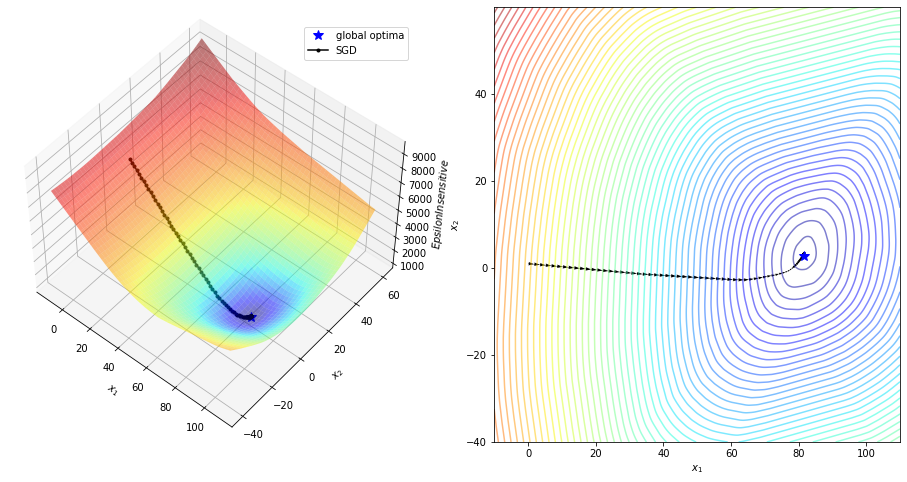

In [29]:
grid = GridSearchCV(PrimalSVR(loss=epsilon_insensitive, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='none', 
                              early_stopping=True, 
                              max_iter=20000, 
                              tol=1e-8, 
                              random_state=123456),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    refit='r2',  # refit the best model (wrt r2)
                    return_train_score=True,
                    verbose=2).fit(lin_X, lin_y)

eps_loss = plot_surface_contour(grid.best_estimator_.loss, 
                                x_min=-10, x_max=110, y_min=-40, y_max=60)
eps_loss_opt = plot_trajectory_optimization(eps_loss, grid.best_estimator_.optimizer, 
                                            color='k', label='SGD')

In [30]:
none_primal_l1_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
none_primal_l1_svr_cv_results.insert(0, 'solver', 'sgd')
none_primal_l1_svr_cv_results.insert(1, 'momentum', 'none')
none_primal_l1_svr_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
none_primal_l1_svr_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                   
sgd    none     1   0.1      13.207407  0.954298   16161   100
                    0.2       9.523358  0.954544   12267    99
                    0.3      11.594773  0.955424   13665    99
                10  0.1       0.690761  0.983893     806    98
                    0.2       0.722907  0.983891     884    98
                    0.3       0.756686  0.983884     958    97
                100 0.1       0.121053  0.984034      85    97
                    0.2       0.088140  0.984047      96    98
                    0.3       0.156799  0.984056     109    98

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...................................C=1, epsilon=0.1; total time=   7.9s
[CV] END ...................................C=1, epsilon=0.2; total time=   5.9s
[CV] END ...................................C=1, epsilon=0.3; total time=   7.0s
[CV] END ..................................C=10, epsilon=0.1; total time=   0.6s
[CV] END ..................................C=10, epsilon=0.2; total time=   0.5s
[CV] END ..................................C=10, epsilon=0.3; total time=   0.7s
[CV] END .................................C=100, epsilon=0.1; total time=   0.2s
[CV] END .................................C=100, epsilon=0.2; total time=   0.2s
[CV] END .................................C=100, epsilon=0.3; total time=   0.2s


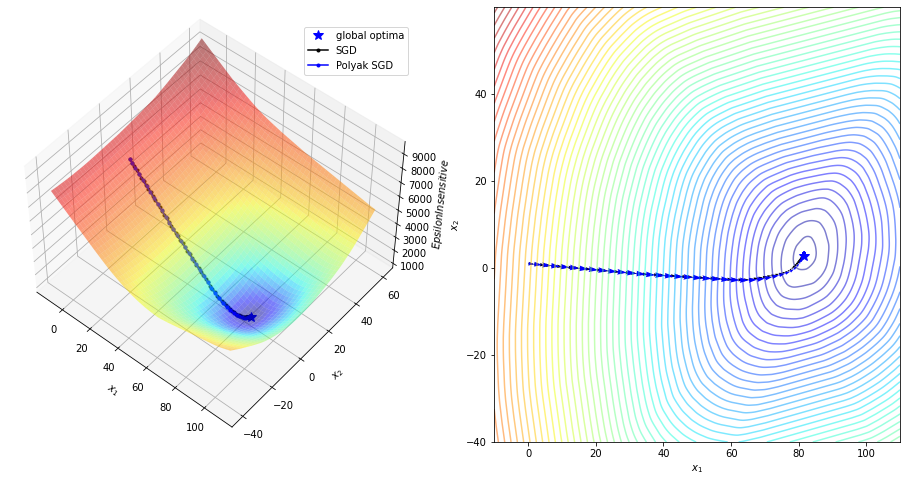

In [31]:
grid = GridSearchCV(PrimalSVR(loss=epsilon_insensitive, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='polyak', 
                              momentum=0.4, 
                              early_stopping=True, 
                              max_iter=20000, 
                              tol=1e-8, 
                              random_state=123456),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    refit='r2',  # refit the best model (wrt r2)
                    return_train_score=True,
                    verbose=2).fit(lin_X, lin_y)

eps_loss_opt = plot_trajectory_optimization(eps_loss_opt, grid.best_estimator_.optimizer, 
                                            color='b', label='Polyak SGD')
eps_loss_opt

In [32]:
polyak_primal_l1_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
polyak_primal_l1_svr_cv_results.insert(0, 'solver', 'sgd')
polyak_primal_l1_svr_cv_results.insert(1, 'momentum', 'polyak')
polyak_primal_l1_svr_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
polyak_primal_l1_svr_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    polyak   1   0.1      7.895537  0.954321    9874   100
                    0.2      5.816864  0.954549    7400    99
                    0.3      6.935173  0.955424    8200    99
                10  0.1      0.489926  0.983893     487    97
                    0.2      0.503936  0.983891     535    98
                    0.3      0.483785  0.983885     569    98
                100 0.1      0.090085  0.984030      48    98
                    0.2      0.108489  0.984046      56    98
                    0.3      0.114756  0.984055      61    97

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...................................C=1, epsilon=0.1; total time=   9.1s
[CV] END ...................................C=1, epsilon=0.2; total time=   6.0s
[CV] END ...................................C=1, epsilon=0.3; total time=   7.6s
[CV] END ..................................C=10, epsilon=0.1; total time=   0.9s
[CV] END ..................................C=10, epsilon=0.2; total time=   0.5s
[CV] END ..................................C=10, epsilon=0.3; total time=   0.7s
[CV] END .................................C=100, epsilon=0.1; total time=   0.3s
[CV] END .................................C=100, epsilon=0.2; total time=   0.2s
[CV] END .................................C=100, epsilon=0.3; total time=   0.2s


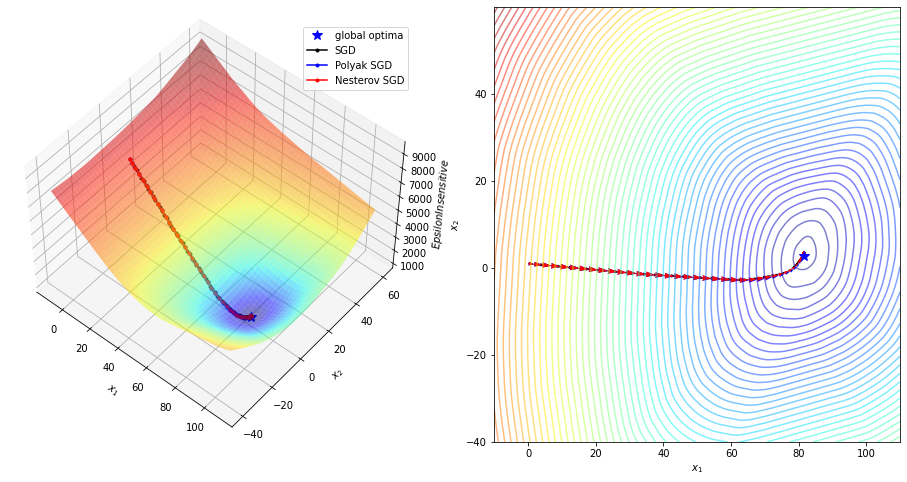

In [33]:
grid = GridSearchCV(PrimalSVR(loss=epsilon_insensitive, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='nesterov', 
                              momentum=0.4, 
                              early_stopping=True, 
                              max_iter=20000, 
                              tol=1e-8, 
                              random_state=123456),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    refit='r2',  # refit the best model (wrt r2)
                    return_train_score=True,
                    verbose=2).fit(lin_X, lin_y)

eps_loss_opt = plot_trajectory_optimization(eps_loss_opt, grid.best_estimator_.optimizer, 
                                            color='r', label='Nesterov SGD')
eps_loss_opt.savefig('./tex/img/l1_svr_loss.png')
eps_loss_opt

In [34]:
nesterov_primal_l1_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nesterov_primal_l1_svr_cv_results.insert(0, 'solver', 'sgd')
nesterov_primal_l1_svr_cv_results.insert(1, 'momentum', 'nesterov')
nesterov_primal_l1_svr_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
nesterov_primal_l1_svr_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    nesterov 1   0.1      8.996545  0.954310    9785   100
                    0.2      6.001156  0.954546    7382    99
                    0.3      7.318327  0.955424    8198    99
                10  0.1      0.803194  0.983892     489    97
                    0.2      0.457146  0.983890     533    97
                    0.3      0.561535  0.983884     579    98
                100 0.1      0.097744  0.984031      61    98
                    0.2      0.120314  0.984047      58    98
                    0.3      0.107943  0.984057      62    98

In [35]:
custom_primal_l1_svr_cv_results = none_primal_l1_svr_cv_results.append(
    polyak_primal_l1_svr_cv_results).append(
    nesterov_primal_l1_svr_cv_results)
custom_primal_l1_svr_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                   
sgd    none     1   0.1      13.207407  0.954298   16161   100
                    0.2       9.523358  0.954544   12267    99
                    0.3      11.594773  0.955424   13665    99
                10  0.1       0.690761  0.983893     806    98
                    0.2       0.722907  0.983891     884    98
                    0.3       0.756686  0.983884     958    97
                100 0.1       0.121053  0.984034      85    97
                    0.2       0.088140  0.984047      96    98
                    0.3       0.156799  0.984056     109    98
       polyak   1   0.1       7.895537  0.954321    9874   100
                    0.2       5.816864  0.954549    7400    99
                    0.3       6.935173  0.955424    8200    99
                10  0.1       0.489926  0.983893     487    97
                    0.2       0.503936  0.983891     535    98
                    0.3       0.483785  0.983885     569    98
                100 0.1       0.090085  0.984030      48    98
                    0.2       0.108489  0.984046      56    98
                    0.3       0.114756  0.984055      61    97
       nesterov 1   0.1       8.996545  0.954310    9785   100
                    0.2       6.001156  0.954546    7382    99
                    0.3       7.318327  0.955424    8198    99
                10  0.1       0.803194  0.983892     489    97
                    0.2       0.457146  0.983890     533    97
                    0.3       0.561535  0.983884     579    98
                100 0.1       0.097744  0.984031      61    98
                    0.2       0.120314  0.984047      58    98
                    0.3       0.107943  0.984057      62    98

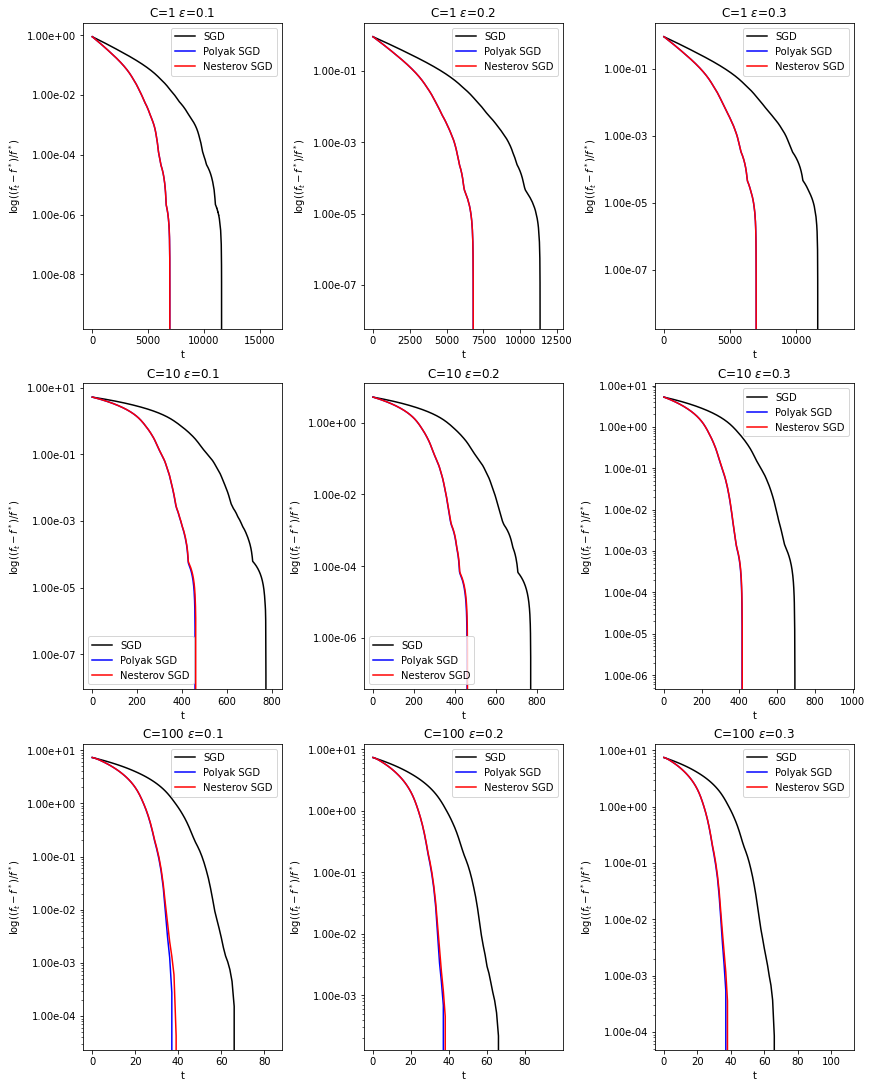

In [36]:
colors = {'none': ('k', 'SGD'),
          'polyak': ('b', 'Polyak SGD'),
          'nesterov': ('r', 'Nesterov SGD')}
axes = plt.figure(figsize=(12, 15), constrained_layout=True).subplots(3, 3)
for momentum, _dict1 in train_loss_history.items():
    for (C, _dict2), row_ax in zip(_dict1.items(), axes):
        for (eps, history), loss in zip(_dict2.items(), row_ax):
            loss.plot(history, color=colors[momentum][0], label=colors[momentum][1])
            loss.set_title('C={:d} $\epsilon$={:.1f}'.format(C, eps))
            loss.set_xlabel('t')
            loss.set_yscale('log')
            loss.set_ylabel('$\log((f_t - f^*) / f^*)$')
            loss.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
            loss.legend().get_frame().set_facecolor('white')
plt.savefig('./tex/img/l1_svr_loss_history.png')

In [37]:
grid = GridSearchCV(SkLinearSVR(loss='epsilon_insensitive', 
                                max_iter=20000,
                                random_state=123456),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2)
                    return_train_score=True,
                    verbose=2).fit(lin_X, lin_y)

Fitting 1 folds for each of 9 candidates, totalling 9 fits


In [38]:
liblinear_primal_l1_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_l1_svr_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_l1_svr_cv_results.insert(1, 'momentum', '-')
liblinear_primal_l1_svr_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
liblinear_primal_l1_svr_cv_results

fit_time        r2  n_iter  n_sv
solver    momentum C   epsilon                                  
liblinear -        1   0.1      0.019717  0.954684      12   100
                       0.2      0.001534  0.955112      10    99
                       0.3      0.001302  0.955415      10    97
                   10  0.1      0.002194  0.983893      57    99
                       0.2      0.001483  0.983890      69    98
                       0.3      0.001968  0.983906     142    97
                   100 0.1      0.001972  0.984023     980    97
                       0.2      0.006431  0.984028    1340    97
                       0.3      0.002328  0.984051    2886    97

In [39]:
primal_l1_svr_cv_results = custom_primal_l1_svr_cv_results.append(liblinear_primal_l1_svr_cv_results)
primal_l1_svr_cv_results.to_latex('./tex/experiments/primal_l1_svr.tex', 
                                  caption='Results for the primal formulation of the $\protect \mathcal{L}_1$-SVR', 
                                  label='primal_l1_svr_cv_results', position='H')
primal_l1_svr_cv_results

fit_time        r2  n_iter  n_sv
solver    momentum C   epsilon                                   
sgd       none     1   0.1      13.207407  0.954298   16161   100
                       0.2       9.523358  0.954544   12267    99
                       0.3      11.594773  0.955424   13665    99
                   10  0.1       0.690761  0.983893     806    98
                       0.2       0.722907  0.983891     884    98
                       0.3       0.756686  0.983884     958    97
                   100 0.1       0.121053  0.984034      85    97
                       0.2       0.088140  0.984047      96    98
                       0.3       0.156799  0.984056     109    98
          polyak   1   0.1       7.895537  0.954321    9874   100
                       0.2       5.816864  0.954549    7400    99
                       0.3       6.935173  0.955424    8200    99
                   10  0.1       0.489926  0.983893     487    97
                       0.2       0.503936  0.983891     535    98
                       0.3       0.483785  0.983885     569    98
                   100 0.1       0.090085  0.984030      48    98
                       0.2       0.108489  0.984046      56    98
                       0.3       0.114756  0.984055      61    97
          nesterov 1   0.1       8.996545  0.954310    9785   100
                       0.2       6.001156  0.954546    7382    99
                       0.3       7.318327  0.955424    8198    99
                   10  0.1       0.803194  0.983892     489    97
                       0.2       0.457146  0.983890     533    97
                       0.3       0.561535  0.983884     579    98
                   100 0.1       0.097744  0.984031      61    98
                       0.2       0.120314  0.984047      58    98
                       0.3       0.107943  0.984057      62    98
liblinear -        1   0.1       0.019717  0.954684      12   100
                       0.2       0.001534  0.955112      10    99
                       0.3       0.001302  0.955415      10    97
                   10  0.1       0.002194  0.983893      57    99
                       0.2       0.001483  0.983890      69    98
                       0.3       0.001968  0.983906     142    97
                   100 0.1       0.001972  0.984023     980    97
                       0.2       0.006431  0.984028    1340    97
                       0.3       0.002328  0.984051    2886    97

### Dual formulations

In [16]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.losses import epsilon_insensitive
from optiml.ml.svm.kernels import LinearKernel, LaplacianKernel, GaussianKernel
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.constrained._base import AugmentedLagrangianQuadratic
from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [17]:
import re
from io import StringIO
from wurlitzer import pipes, STDOUT


class SklSVR(SVR):

    def fit(self, X, y, sample_weight=None):
        out = StringIO()
        with pipes(stdout=out, stderr=STDOUT):
            super(SklSVR, self).fit(X, y, sample_weight)
        self.n_iter_ = int(re.findall(r'%s(\d+)' % '#iter = ', out.getvalue())[0])
        return self

In [18]:
train_loss_history = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

def dual_r2_scorer(svr, X, y):
    
    if (hasattr(svr, 'train_loss_history') and
                isinstance(svr.obj, AugmentedLagrangianQuadratic)):
        
        # (f_t - f*) / f*
        f_star = np.full_like(svr.train_loss_history, svr.obj.f_star())
        dual = 'reg_bias' if svr.reg_intercept else 'unreg_bias'
        kernel = svr.kernel.__class__.__name__
        train_loss_history[dual][kernel][svr.C][svr.epsilon] = np.divide((svr.train_loss_history - f_star), 
                                                                         np.maximum(np.abs(f_star), 1))
        
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SklSVR) else (svr.iter if isinstance(svr.optimizer, str) 
                                                                   else svr.optimizer.iter) + 1,  # starts from 0
            'n_sv': len(svr.support_)}

#### Wolfe Dual

##### Linear

Fitting 1 folds for each of 18 candidates, totalling 18 fits
     pcost       dcost       gap    pres   dres
 0: -1.1167e+04 -2.5701e+05  2e+05  0e+00  9e-15
 1: -6.2479e+04 -9.8509e+04  4e+04  2e-16  1e-14
 2: -8.0376e+04 -8.6953e+04  7e+03  2e-16  9e-15
 3: -8.3021e+04 -8.5265e+04  2e+03  2e-16  1e-14
 4: -8.4092e+04 -8.4496e+04  4e+02  2e-16  1e-14
 5: -8.4260e+04 -8.4362e+04  1e+02  2e-16  1e-14
 6: -8.4314e+04 -8.4316e+04  2e+00  2e-16  1e-14
 7: -8.4315e+04 -8.4315e+04  2e-02  2e-16  1e-14
Optimal solution found.


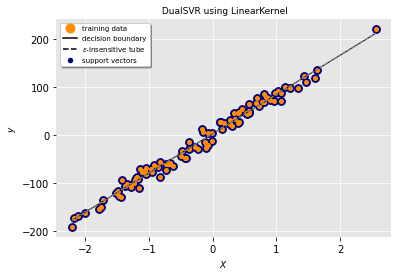

In [43]:
grid = GridSearchCV(DualSVR(loss=epsilon_insensitive, 
                            kernel=LinearKernel()),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2)
                    return_train_score=True,
                    verbose=2).fit(lin_X, lin_y)

plot_svm_hyperplane(grid.best_estimator_, lin_X, lin_y)
plt.savefig('./tex/img/linear_dual_l1_svr_hyperplane.png')

In [44]:
custom_linear_dual_l1_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_linear_dual_l1_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
custom_linear_dual_l1_svr_cv_results.set_index(['solver', 'C', 'epsilon'], inplace=True)
custom_linear_dual_l1_svr_cv_results

fit_time        r2  n_iter  n_sv
solver C   epsilon                                  
cvxopt 1   0.1      0.122198  0.954685       9   100
           0.2      0.152970  0.954849       9   100
           0.3      0.066905  0.955429      10   100
       10  0.1      0.144911  0.983893       9   100
           0.2      0.056698  0.983893       8   100
           0.3      0.045109  0.983893       8   100
       100 0.1      0.094987  0.984071       9   100
           0.2      0.070957  0.984088       9   100
           0.3      0.095619  0.984103       8   100
smo    1   0.1      0.049352  0.954396      10   100
           0.2      0.026155  0.954546      15   100
           0.3      0.090050  0.955429      13    99
       10  0.1      0.201986  0.983893      44    99
           0.2      0.091500  0.983893      48    99
           0.3      0.084329  0.983893      41    99
       100 0.1      0.826075  0.984071     623    98
           0.2      0.409304  0.984088     157    98
           0.3      0.521488  0.984103     334    98

In [45]:
grid = GridSearchCV(SklSVR(kernel='linear', 
                           verbose=True),  # `verbose=True` to capture n_iter
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2)
                    return_train_score=True,
                    verbose=2).fit(lin_X, lin_y)

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[LibSVM]

In [46]:
libsvm_linear_dual_l1_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_linear_dual_l1_svr_cv_results.insert(0, 'solver', 'libsvm')
libsvm_linear_dual_l1_svr_cv_results.set_index(['solver', 'C', 'epsilon'], inplace=True)
libsvm_linear_dual_l1_svr_cv_results

fit_time        r2  n_iter  n_sv
solver C   epsilon                                  
libsvm 1   0.1      0.009594  0.954393      79   100
           0.2      0.005095  0.954543      82   100
           0.3      0.029558  0.955424      78    99
       10  0.1      0.033350  0.983892     206    99
           0.2      0.005173  0.983890     219    99
           0.3      0.009250  0.983885     216    99
       100 0.1      0.019970  0.984028    2239    98
           0.2      0.006288  0.984041    1189    98
           0.3      0.003961  0.984051    1366    98

In [47]:
linear_dual_l1_svr_cv_results = custom_linear_dual_l1_svr_cv_results.append(libsvm_linear_dual_l1_svr_cv_results)
linear_dual_l1_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], ascending=[False, True, True], inplace=True)
linear_dual_l1_svr_cv_results.to_latex('./tex/experiments/linear_dual_l1_svr.tex', 
                                       caption='Results for the Wolfe dual formulation of the linear $\protect \mathcal{L}_1$-SVR', 
                                       label='linear_dual_l1_svr_cv_results', position='H')
linear_dual_l1_svr_cv_results

fit_time        r2  n_iter  n_sv
solver C   epsilon                                  
smo    1   0.1      0.049352  0.954396      10   100
           0.2      0.026155  0.954546      15   100
           0.3      0.090050  0.955429      13    99
       10  0.1      0.201986  0.983893      44    99
           0.2      0.091500  0.983893      48    99
           0.3      0.084329  0.983893      41    99
       100 0.1      0.826075  0.984071     623    98
           0.2      0.409304  0.984088     157    98
           0.3      0.521488  0.984103     334    98
libsvm 1   0.1      0.009594  0.954393      79   100
           0.2      0.005095  0.954543      82   100
           0.3      0.029558  0.955424      78    99
       10  0.1      0.033350  0.983892     206    99
           0.2      0.005173  0.983890     219    99
           0.3      0.009250  0.983885     216    99
       100 0.1      0.019970  0.984028    2239    98
           0.2      0.006288  0.984041    1189    98
           0.3      0.003961  0.984051    1366    98
cvxopt 1   0.1      0.122198  0.954685       9   100
           0.2      0.152970  0.954849       9   100
           0.3      0.066905  0.955429      10   100
       10  0.1      0.144911  0.983893       9   100
           0.2      0.056698  0.983893       8   100
           0.3      0.045109  0.983893       8   100
       100 0.1      0.094987  0.984071       9   100
           0.2      0.070957  0.984088       9   100
           0.3      0.095619  0.984103       8   100

##### Nonlinear

Fitting 1 folds for each of 18 candidates, totalling 18 fits


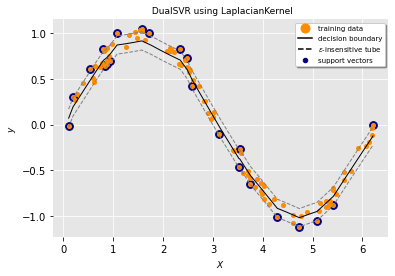

In [48]:
grid = GridSearchCV(DualSVR(loss=epsilon_insensitive),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [LaplacianKernel(gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2)
                    return_train_score=True,
                    verbose=2).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)
plt.savefig('./tex/img/laplacian_dual_l1_svr_hyperplane.png')

In [49]:
laplacian_nonlinear_dual_l2_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
laplacian_nonlinear_dual_l2_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
laplacian_nonlinear_dual_l2_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
laplacian_nonlinear_dual_l2_svr_cv_results

fit_time        r2  n_iter  n_sv
solver kernel    C   epsilon                                  
cvxopt laplacian 1   0.1      0.094410  0.977836       9    24
                     0.2      0.096828  0.942110       9    13
                     0.3      0.145580  0.866633       9     9
                 10  0.1      0.112691  0.984378      10    24
                     0.2      0.133206  0.942110      10    13
                     0.3      0.098581  0.866633      10     9
                 100 0.1      0.071575  0.984378      10    24
                     0.2      0.086546  0.955697      10    14
                     0.3      0.076675  0.888440      10    10
smo    laplacian 1   0.1      0.190778  0.972858      23    23
                     0.2      0.103656  0.942216      21    13
                     0.3      0.073561  0.866739      17     9
                 10  0.1      0.308953  0.989399      19    22
                     0.2      0.110892  0.941932      17    13
                     0.3      0.087622  0.866472      13     9
                 100 0.1      0.237147  0.989399      19    22
                     0.2      0.083979  0.941932      17    13
                     0.3      0.080471  0.866472      13     9

Fitting 1 folds for each of 18 candidates, totalling 18 fits
     pcost       dcost       gap    pres   dres
 0:  9.9722e+02 -2.3019e+04  2e+04  0e+00  1e-12
 1:  8.8761e+02 -1.3911e+03  2e+03  1e-16  1e-12
 2:  1.7095e+02 -1.6286e+02  3e+02  1e-16  1e-12
 3:  2.8000e+01 -5.5447e+01  8e+01  2e-16  5e-13
 4:  1.9850e+00 -3.1537e+01  3e+01  2e-16  3e-13
 5: -1.1406e+01 -1.8729e+01  7e+00  2e-16  3e-13
 6: -1.4158e+01 -1.6108e+01  2e+00  2e-16  3e-13
 7: -1.4924e+01 -1.5333e+01  4e-01  2e-16  3e-13
 8: -1.5103e+01 -1.5153e+01  5e-02  2e-16  2e-13
 9: -1.5127e+01 -1.5128e+01  1e-03  2e-16  3e-13
10: -1.5127e+01 -1.5127e+01  1e-05  2e-16  2e-13
Optimal solution found.


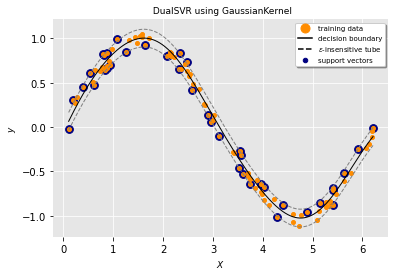

In [50]:
grid = GridSearchCV(DualSVR(loss=epsilon_insensitive),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [GaussianKernel(gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2)
                    return_train_score=True,
                    verbose=2).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)
plt.savefig('./tex/img/gaussian_dual_l1_svr_hyperplane.png')

In [51]:
gaussian_nonlinear_dual_l2_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
gaussian_nonlinear_dual_l2_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
gaussian_nonlinear_dual_l2_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
gaussian_nonlinear_dual_l2_svr_cv_results

fit_time        r2  n_iter  n_sv
solver kernel   C   epsilon                                   
cvxopt gaussian 1   0.1       0.106479  0.988117      10    17
                    0.2       0.060167  0.924679      10     7
                    0.3       0.048079  0.883386      10     5
                10  0.1       0.126220  0.989956      10    18
                    0.2       0.085939  0.925595      10     6
                    0.3       0.109721  0.883386      10     5
                100 0.1       0.097486  0.990216      10    40
                    0.2       0.076151  0.925595      10     6
                    0.3       0.095276  0.883386      10     5
smo    gaussian 1   0.1       0.134567  0.988249      61    17
                    0.2       0.098772  0.924439      18     7
                    0.3       0.058488  0.882880      17     5
                10  0.1       0.628905  0.989828     289    18
                    0.2       0.073629  0.924770      27     6
                    0.3       0.034380  0.883067      13     5
                100 0.1      10.473704  0.899765    4835    17
                    0.2       0.087404  0.924770      27     6
                    0.3       0.023395  0.883067      13     5

In [52]:
custom_nonlinear_dual_l2_svr_cv_results = laplacian_nonlinear_dual_l2_svr_cv_results.append(gaussian_nonlinear_dual_l2_svr_cv_results)
custom_nonlinear_dual_l2_svr_cv_results.sort_values(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
custom_nonlinear_dual_l2_svr_cv_results

fit_time        r2  n_iter  n_sv
solver kernel    C   epsilon                                   
cvxopt gaussian  1   0.1       0.106479  0.988117      10    17
                     0.2       0.060167  0.924679      10     7
                     0.3       0.048079  0.883386      10     5
                 10  0.1       0.126220  0.989956      10    18
                     0.2       0.085939  0.925595      10     6
                     0.3       0.109721  0.883386      10     5
                 100 0.1       0.097486  0.990216      10    40
                     0.2       0.076151  0.925595      10     6
                     0.3       0.095276  0.883386      10     5
       laplacian 1   0.1       0.094410  0.977836       9    24
                     0.2       0.096828  0.942110       9    13
                     0.3       0.145580  0.866633       9     9
                 10  0.1       0.112691  0.984378      10    24
                     0.2       0.133206  0.942110      10    13
                     0.3       0.098581  0.866633      10     9
                 100 0.1       0.071575  0.984378      10    24
                     0.2       0.086546  0.955697      10    14
                     0.3       0.076675  0.888440      10    10
smo    gaussian  1   0.1       0.134567  0.988249      61    17
                     0.2       0.098772  0.924439      18     7
                     0.3       0.058488  0.882880      17     5
                 10  0.1       0.628905  0.989828     289    18
                     0.2       0.073629  0.924770      27     6
                     0.3       0.034380  0.883067      13     5
                 100 0.1      10.473704  0.899765    4835    17
                     0.2       0.087404  0.924770      27     6
                     0.3       0.023395  0.883067      13     5
       laplacian 1   0.1       0.190778  0.972858      23    23
                     0.2       0.103656  0.942216      21    13
                     0.3       0.073561  0.866739      17     9
                 10  0.1       0.308953  0.989399      19    22
                     0.2       0.110892  0.941932      17    13
                     0.3       0.087622  0.866472      13     9
                 100 0.1       0.237147  0.989399      19    22
                     0.2       0.083979  0.941932      17    13
                     0.3       0.080471  0.866472      13     9

In [53]:
grid = GridSearchCV(SklSVR(verbose=True),  # `verbose=True` to capture n_iter
                    param_grid=[{'epsilon': [0.1, 0.2, 0.3],
                                 'C': [1, 10, 100],
                                 'kernel': [LaplacianKernel(gamma='scale')]},
                                {'epsilon': [0.1, 0.2, 0.3],
                                 'C': [1, 10, 100],
                                 'kernel': ['rbf'],
                                 'gamma': ['scale']}],
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2)
                    return_train_score=True,
                    verbose=2).fit(nonlin_X, nonlin_y)

Fitting 1 folds for each of 18 candidates, totalling 18 fits
[LibSVM]

In [54]:
libsvm_nonlinear_dual_l2_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_nonlinear_dual_l2_svr_cv_results.insert(0, 'solver', 'libsvm')
libsvm_nonlinear_dual_l2_svr_cv_results.sort_values(['kernel', 'C', 'epsilon'], inplace=True)
libsvm_nonlinear_dual_l2_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
libsvm_nonlinear_dual_l2_svr_cv_results

fit_time        r2  n_iter  n_sv
solver kernel    C   epsilon                                  
libsvm gaussian  1   0.1      0.009212  0.990088      96    17
                     0.2      0.007524  0.977763      36     7
                     0.3      0.002327  0.945601      24     5
                 10  0.1      0.006896  0.990493     616    18
                     0.2      0.008819  0.980673      39     6
                     0.3      0.002239  0.945601      24     5
                 100 0.1      0.010395  0.990496    9854    18
                     0.2      0.002149  0.980673      39     6
                     0.3      0.001906  0.945601      24     5
       laplacian 1   0.1      0.019776  0.990050      47    23
                     0.2      0.006970  0.969067      28    13
                     0.3      0.005510  0.924296      22     9
                 10  0.1      0.002124  0.990777      47    23
                     0.2      0.007089  0.969103      31    13
                     0.3      0.002430  0.924237      22     9
                 100 0.1      0.005186  0.990777      47    23
                     0.2      0.002676  0.969103      31    13
                     0.3      0.005486  0.924237      22     9

In [55]:
nonlinear_dual_l2_svr_cv_results = custom_nonlinear_dual_l2_svr_cv_results.append(libsvm_nonlinear_dual_l2_svr_cv_results)
nonlinear_dual_l2_svr_cv_results.sort_values(['solver', 'kernel'], ascending=[False, True], inplace=True)
nonlinear_dual_l2_svr_cv_results.to_latex('./tex/experiments/nonlinear_dual_l1_svr.tex', 
                                          caption='Results for the Wolfe dual formulation of the nonlinear $\protect \mathcal{L}_1$-SVR', 
                                          label='nonlinear_dual_l1_svr_cv_results', position='H')
nonlinear_dual_l2_svr_cv_results

fit_time        r2  n_iter  n_sv
solver kernel    C   epsilon                                   
smo    gaussian  1   0.1       0.134567  0.988249      61    17
                     0.2       0.098772  0.924439      18     7
                     0.3       0.058488  0.882880      17     5
                 10  0.1       0.628905  0.989828     289    18
                     0.2       0.073629  0.924770      27     6
                     0.3       0.034380  0.883067      13     5
                 100 0.1      10.473704  0.899765    4835    17
                     0.2       0.087404  0.924770      27     6
                     0.3       0.023395  0.883067      13     5
       laplacian 1   0.1       0.190778  0.972858      23    23
                     0.2       0.103656  0.942216      21    13
                     0.3       0.073561  0.866739      17     9
                 10  0.1       0.308953  0.989399      19    22
                     0.2       0.110892  0.941932      17    13
                     0.3       0.087622  0.866472      13     9
                 100 0.1       0.237147  0.989399      19    22
                     0.2       0.083979  0.941932      17    13
                     0.3       0.080471  0.866472      13     9
libsvm gaussian  1   0.1       0.009212  0.990088      96    17
                     0.2       0.007524  0.977763      36     7
                     0.3       0.002327  0.945601      24     5
                 10  0.1       0.006896  0.990493     616    18
                     0.2       0.008819  0.980673      39     6
                     0.3       0.002239  0.945601      24     5
                 100 0.1       0.010395  0.990496    9854    18
                     0.2       0.002149  0.980673      39     6
                     0.3       0.001906  0.945601      24     5
       laplacian 1   0.1       0.019776  0.990050      47    23
                     0.2       0.006970  0.969067      28    13
                     0.3       0.005510  0.924296      22     9
                 10  0.1       0.002124  0.990777      47    23
                     0.2       0.007089  0.969103      31    13
                     0.3       0.002430  0.924237      22     9
                 100 0.1       0.005186  0.990777      47    23
                     0.2       0.002676  0.969103      31    13
                     0.3       0.005486  0.924237      22     9
cvxopt gaussian  1   0.1       0.106479  0.988117      10    17
                     0.2       0.060167  0.924679      10     7
                     0.3       0.048079  0.883386      10     5
                 10  0.1       0.126220  0.989956      10    18
                     0.2       0.085939  0.925595      10     6
                     0.3       0.109721  0.883386      10     5
                 100 0.1       0.097486  0.990216      10    40
                     0.2       0.076151  0.925595      10     6
                     0.3       0.095276  0.883386      10     5
       laplacian 1   0.1       0.094410  0.977836       9    24
                     0.2       0.096828  0.942110       9    13
                     0.3       0.145580  0.866633       9     9
                 10  0.1       0.112691  0.984378      10    24
                     0.2       0.133206  0.942110      10    13
                     0.3       0.098581  0.866633      10     9
                 100 0.1       0.071575  0.984378      10    24
                     0.2       0.086546  0.955697      10    14
                     0.3       0.076675  0.888440      10    10

#### Lagrangian Dual

##### Linear

In [19]:
grid = GridSearchCV(DualSVR(loss=epsilon_insensitive, 
                            kernel=LinearKernel(), 
                            optimizer=AdaGrad, 
                            max_iter=1000000, 
                            learning_rate=1., 
                            tol=1e-6, 
                            random_state=123456),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'reg_intercept': [True, False]},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    refit=False,
                    return_train_score=True,
                    verbose=2).fit(lin_X, lin_y)

Fitting 1 folds for each of 18 candidates, totalling 18 fits
[CV] END ...............C=1, epsilon=0.1, reg_intercept=True; total time=  23.9s
[CV] END ..............C=1, epsilon=0.1, reg_intercept=False; total time=  49.8s
[CV] END ...............C=1, epsilon=0.2, reg_intercept=True; total time=  31.5s
[CV] END ..............C=1, epsilon=0.2, reg_intercept=False; total time= 1.4min
[CV] END ...............C=1, epsilon=0.3, reg_intercept=True; total time=  24.6s
[CV] END ..............C=1, epsilon=0.3, reg_intercept=False; total time= 5.2min
[CV] END ..............C=10, epsilon=0.1, reg_intercept=True; total time=  44.0s
[CV] END .............C=10, epsilon=0.1, reg_intercept=False; total time= 1.1min
[CV] END ..............C=10, epsilon=0.2, reg_intercept=True; total time=  43.2s
[CV] END .............C=10, epsilon=0.2, reg_intercept=False; total time= 1.4min
[CV] END ..............C=10, epsilon=0.3, reg_intercept=True; total time= 1.0min
[CV] END .............C=10, epsilon=0.3, reg_int

In [20]:
linear_lagrangian_dual_l2_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
linear_lagrangian_dual_l2_svr_cv_results.sort_values(['dual', 'C'], inplace=True)
linear_lagrangian_dual_l2_svr_cv_results.set_index(['dual', 'C', 'epsilon'], inplace=True)
linear_lagrangian_dual_l2_svr_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_l1_svr.tex', 
                                                  caption='Results for the Lagrangian dual formulation of the linear $\protect \mathcal{L}_1$-SVR', 
                                                  label='linear_lagrangian_dual_l1_svr_cv_results', position='H')
linear_lagrangian_dual_l2_svr_cv_results

fit_time        r2  n_iter  n_sv
dual       C   epsilon                                    
reg_bias   1   0.1       23.881113  0.954685   22445   100
               0.2       31.481934  0.954845   22235   100
               0.3       24.310760  0.955429   21493    99
           10  0.1       43.878878  0.983893   24700    99
               0.2       43.092336  0.983893   26586    99
               0.3       60.609057  0.983893   26076    99
           100 0.1      151.873868  0.984071  105273    98
               0.2      173.833673  0.984088  141626    98
               0.3      259.661015  0.984103  284365    98
unreg_bias 1   0.1       49.656317  0.954396   24597   100
               0.2       83.297098  0.954546   62678   100
               0.3      313.268643  0.955429  332397    99
           10  0.1       67.435317  0.983893   55824    99
               0.2       85.381756  0.983893   56708    99
               0.3      100.468285  0.983893   62786    99
           100 0.1      675.775826  0.984071  491963    98
               0.2      636.590656  0.984088  541088    98
               0.3      634.562593  0.984103  674048    98

##### Nonlinear

In [22]:
grid = GridSearchCV(DualSVR(loss=epsilon_insensitive, 
                            optimizer=AdaGrad, 
                            max_iter=15000000, 
                            learning_rate=1., 
                            tol=1e-6, 
                            random_state=123456),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [GaussianKernel(gamma='scale'),
                                           LaplacianKernel(gamma='scale')],
                                'reg_intercept': [True, False]},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    refit=False,
                    return_train_score=True,
                    verbose=2).fit(nonlin_X, nonlin_y)

Fitting 1 folds for each of 36 candidates, totalling 36 fits
[CV] END C=1, epsilon=0.1, kernel=GaussianKernel(), reg_intercept=True; total time= 1.9min
[CV] END C=1, epsilon=0.1, kernel=GaussianKernel(), reg_intercept=False; total time= 3.1min
[CV] END C=1, epsilon=0.1, kernel=LaplacianKernel(), reg_intercept=True; total time= 1.7min
[CV] END C=1, epsilon=0.1, kernel=LaplacianKernel(), reg_intercept=False; total time= 2.2min
[CV] END C=1, epsilon=0.2, kernel=GaussianKernel(), reg_intercept=True; total time= 1.2min
[CV] END C=1, epsilon=0.2, kernel=GaussianKernel(), reg_intercept=False; total time= 1.6min
[CV] END C=1, epsilon=0.2, kernel=LaplacianKernel(), reg_intercept=True; total time=  42.7s
[CV] END C=1, epsilon=0.2, kernel=LaplacianKernel(), reg_intercept=False; total time= 1.1min
[CV] END C=1, epsilon=0.3, kernel=GaussianKernel(), reg_intercept=True; total time=  16.3s
[CV] END C=1, epsilon=0.3, kernel=GaussianKernel(), reg_intercept=False; total time=  31.9s
[CV] END C=1, epsilo

/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:2052: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',


[CV] END C=100, epsilon=0.1, kernel=GaussianKernel(), reg_intercept=True; total time=238.7min


/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:2052: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',


[CV] END C=100, epsilon=0.1, kernel=GaussianKernel(), reg_intercept=False; total time=268.3min
[CV] END C=100, epsilon=0.1, kernel=LaplacianKernel(), reg_intercept=True; total time= 2.1min
[CV] END C=100, epsilon=0.1, kernel=LaplacianKernel(), reg_intercept=False; total time= 2.6min
[CV] END C=100, epsilon=0.2, kernel=GaussianKernel(), reg_intercept=True; total time=  20.3s
[CV] END C=100, epsilon=0.2, kernel=GaussianKernel(), reg_intercept=False; total time=  35.4s
[CV] END C=100, epsilon=0.2, kernel=LaplacianKernel(), reg_intercept=True; total time=  39.4s
[CV] END C=100, epsilon=0.2, kernel=LaplacianKernel(), reg_intercept=False; total time= 1.0min
[CV] END C=100, epsilon=0.3, kernel=GaussianKernel(), reg_intercept=True; total time=  14.9s
[CV] END C=100, epsilon=0.3, kernel=GaussianKernel(), reg_intercept=False; total time=  29.8s
[CV] END C=100, epsilon=0.3, kernel=LaplacianKernel(), reg_intercept=True; total time=  35.7s
[CV] END C=100, epsilon=0.3, kernel=LaplacianKernel(), reg_

In [23]:
nonlinear_lagrangian_dual_l2_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_lagrangian_dual_l2_svr_cv_results.sort_values(['dual', 'kernel'], inplace=True)
nonlinear_lagrangian_dual_l2_svr_cv_results.set_index(['dual', 'kernel', 'C', 'epsilon'], inplace=True)
nonlinear_lagrangian_dual_l2_svr_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_l1_svr.tex', 
                                                     caption='Results for the Lagrangian dual formulation of the nonlinear $\protect \mathcal{L}_1$-SVR', 
                                                     label='nonlinear_lagrangian_dual_l1_svr_cv_results', position='H')
nonlinear_lagrangian_dual_l2_svr_cv_results

fit_time        r2    n_iter  n_sv
dual       kernel    C   epsilon                                        
reg_bias   gaussian  1   0.1        111.601558  0.986552     74000    18
                         0.2         70.903437  0.924632     55279     7
                         0.3         16.208501  0.883390     16276     5
                     10  0.1       2822.635816  0.989960   2374361    18
                         0.2         22.066400  0.925601     22218     6
                         0.3         16.195096  0.883389     16343     5
                     100 0.1      14317.367662  0.980160  15000000    18
                         0.2         20.269639  0.925601     22218     6
                         0.3         14.782676  0.883389     16343     5
           laplacian 1   0.1        103.953975  0.972770     70711    23
                         0.2         42.685355  0.942106     42174    13
                         0.3         36.733156  0.866627     36581     9
                     10  0.1        131.796422  0.980896    139542    23
                         0.2         42.588771  0.942106     42306    13
                         0.3         35.705965  0.866627     36794     9
                     100 0.1        127.519553  0.980896    139542    23
                         0.2         39.335263  0.942106     42306    13
                         0.3         35.603758  0.866627     36794     9
unreg_bias gaussian  1   0.1        188.178750  0.986529    135570    18
                         0.2         95.118488  0.924626     77147     7
                         0.3         31.841228  0.883584     32042     5
                     10  0.1       2151.857516  0.989943   2206809    18
                         0.2         37.087099  0.925926     39439     6
                         0.3         31.477857  0.883584     31985     5
                     100 0.1      16094.853187  0.901966  15000000    17
                         0.2         35.356431  0.925926     39439     6
                         0.3         29.743446  0.883584     31985     5
           laplacian 1   0.1        132.727434  0.977780    105076    24
                         0.2         65.892764  0.942111     66657    13
                         0.3         60.492692  0.866660     57945     9
                     10  0.1        169.872154  0.980911    174852    23
                         0.2         64.007585  0.942111     66605    13
                         0.3         54.337485  0.866660     57924     9
                     100 0.1        155.673695  0.980911    174852    23
                         0.2         61.316028  0.942111     66605    13
                         0.3         53.416449  0.866660     57924     9

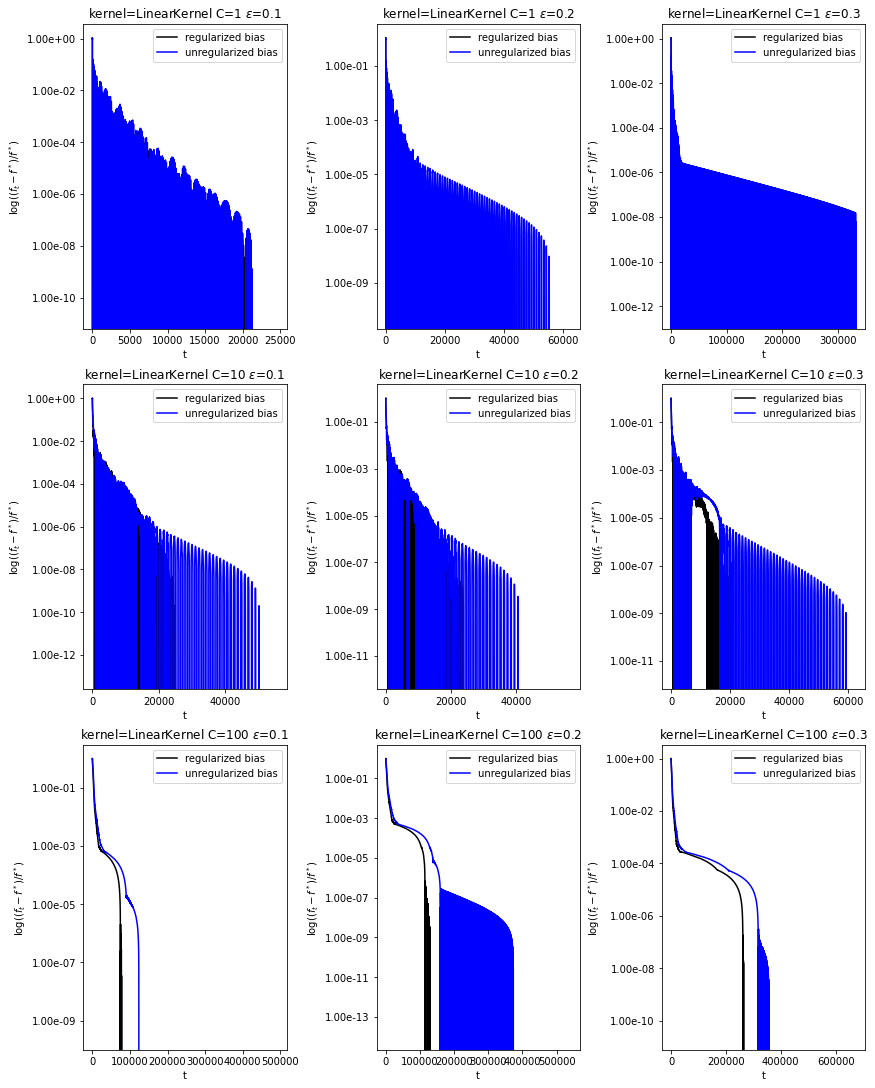

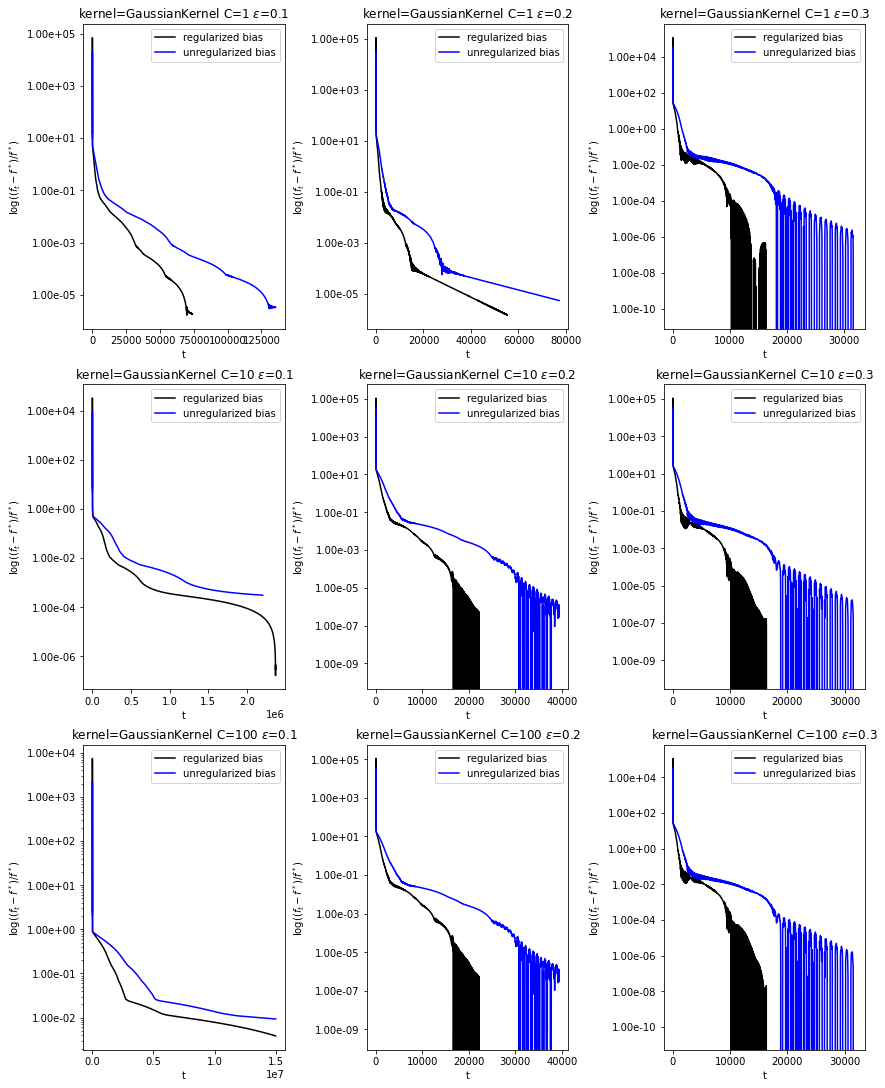

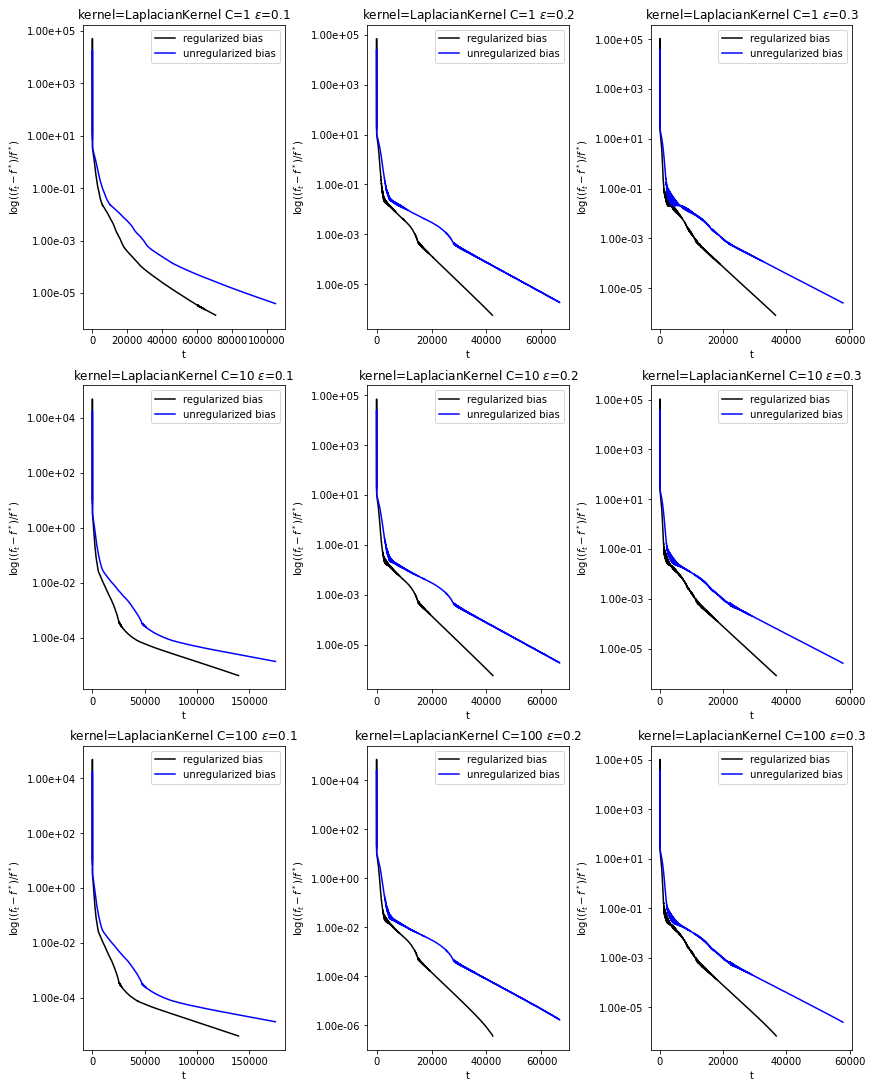

In [24]:
colors = {'reg_bias': ('k', 'regularized bias'),
          'unreg_bias': ('b', 'unregularized bias')}
linear_fig = plt.figure(figsize=(12, 15), constrained_layout=True)
linear_ax = linear_fig.subplots(3, 3)
gaussian_fig = plt.figure(figsize=(12, 15), constrained_layout=True)
gaussian_ax = gaussian_fig.subplots(3, 3)
laplacian_fig = plt.figure(figsize=(12, 15), constrained_layout=True)
laplacian_ax = laplacian_fig.subplots(3, 3)
axes = {'LinearKernel': linear_ax,
        'LaplacianKernel': laplacian_ax,
        'GaussianKernel': gaussian_ax}
for dual, _dict1 in train_loss_history.items():
    for kernel, _dict2 in _dict1.items():
        for (C, _dict3), row_ax in zip(_dict2.items(), axes[kernel]):
            for (eps, history), loss in zip(_dict3.items(), row_ax):
                loss.plot(history, color=colors[dual][0], label=colors[dual][1])
                loss.set_title('kernel={} C={:d} $\epsilon$={:.1f}'.format(kernel, C, eps))
                loss.set_xlabel('t')
                loss.set_yscale('log')
                loss.set_ylabel('$\log((f_t - f^*) / f^*)$')
                loss.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
                loss.legend().get_frame().set_facecolor('white')
linear_fig.savefig('./tex/img/linear_lagrangian_dual_l1_svr_loss_history.png')
gaussian_fig.savefig('./tex/img/gaussian_lagrangian_dual_l1_svr_loss_history.png')
laplacian_fig.savefig('./tex/img/laplacian_lagrangian_dual_l1_svr_loss_history.png')

## Squared Epsilon-insensitive loss

### Primal formulation

In [56]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import squared_epsilon_insensitive

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.svm import LinearSVR as SkLinearSVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [57]:
train_loss_history = defaultdict(lambda: defaultdict(dict))

def primal_r2_scorer(svr, X, y):
    
    if hasattr(svr, 'train_loss_history'):
        
        # (f_t - f*) / f*
        f_star = np.full_like(svr.train_loss_history, svr.loss.f_star())
        train_loss_history[svr.momentum_type][svr.C][svr.epsilon] = np.divide((svr.train_loss_history - f_star), 
                                                                              np.maximum(np.abs(f_star), 1))
        
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SkLinearSVR) else svr.optimizer.iter + 1,  # starts from 0
            'n_sv': len(np.argwhere(np.abs(lin_y - svr.predict(lin_X)) >= svr.epsilon).ravel())}

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...................................C=1, epsilon=0.1; total time=   2.6s
[CV] END ...................................C=1, epsilon=0.2; total time=   2.6s
[CV] END ...................................C=1, epsilon=0.3; total time=   2.7s
[CV] END ..................................C=10, epsilon=0.1; total time=   0.4s
[CV] END ..................................C=10, epsilon=0.2; total time=   0.4s
[CV] END ..................................C=10, epsilon=0.3; total time=   0.4s
[CV] END .................................C=100, epsilon=0.1; total time=   0.1s
[CV] END .................................C=100, epsilon=0.2; total time=   0.1s
[CV] END .................................C=100, epsilon=0.3; total time=   0.1s


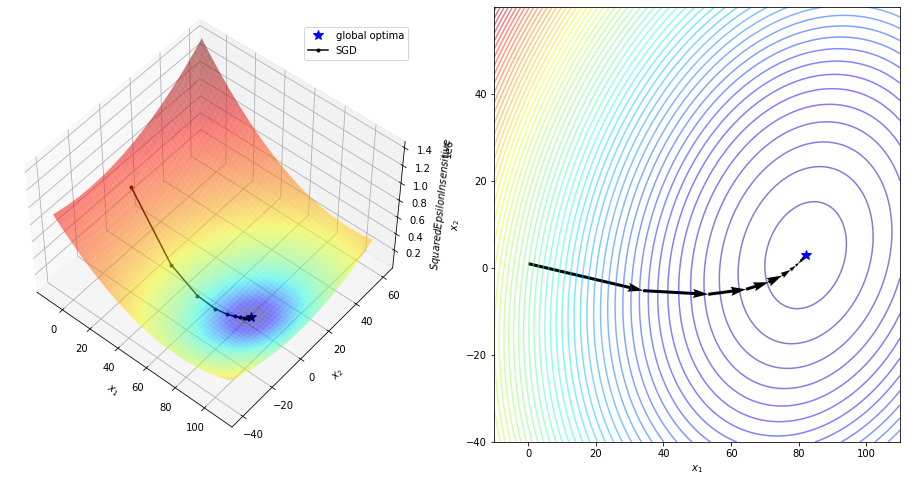

In [58]:
grid = GridSearchCV(PrimalSVR(loss=squared_epsilon_insensitive, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.002, 
                              momentum_type='none', 
                              early_stopping=True, 
                              max_iter=10000, 
                              tol=1e-8, 
                              random_state=123456),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    refit='r2',  # refit the best model (wrt r2)
                    return_train_score=True,
                    verbose=2).fit(lin_X, lin_y)

squared_eps_loss = plot_surface_contour(grid.best_estimator_.loss, 
                                        x_min=-10, x_max=110, y_min=-40, y_max=60)
squared_eps_loss_opt = plot_trajectory_optimization(squared_eps_loss, grid.best_estimator_.optimizer, 
                                                    color='k', label='SGD')

In [59]:
none_primal_l2_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
none_primal_l2_svr_cv_results.insert(0, 'solver', 'sgd')
none_primal_l2_svr_cv_results.insert(1, 'momentum', 'none')
none_primal_l2_svr_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
none_primal_l2_svr_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    none     1   0.1      2.610538  0.984109    3283   100
                    0.2      2.536275  0.984109    3294   100
                    0.3      2.622454  0.984109    3321    98
                10  0.1      0.373240  0.984133     409    98
                    0.2      0.373901  0.984133     410    98
                    0.3      0.406998  0.984133     411    98
                100 0.1      0.086858  0.984133      47    98
                    0.2      0.064771  0.984133      47    98
                    0.3      0.034043  0.984133      47    98

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...................................C=1, epsilon=0.1; total time=   1.7s
[CV] END ...................................C=1, epsilon=0.2; total time=   1.7s
[CV] END ...................................C=1, epsilon=0.3; total time=   1.9s
[CV] END ..................................C=10, epsilon=0.1; total time=   0.3s
[CV] END ..................................C=10, epsilon=0.2; total time=   0.3s
[CV] END ..................................C=10, epsilon=0.3; total time=   0.3s
[CV] END .................................C=100, epsilon=0.1; total time=   0.1s
[CV] END .................................C=100, epsilon=0.2; total time=   0.1s
[CV] END .................................C=100, epsilon=0.3; total time=   0.1s


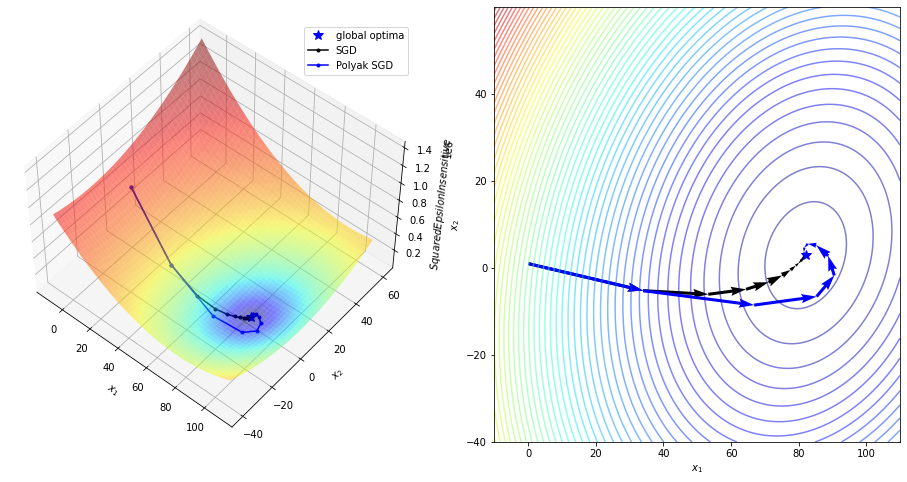

In [60]:
grid = GridSearchCV(PrimalSVR(loss=squared_epsilon_insensitive, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.002, 
                              momentum_type='polyak', 
                              momentum=0.4, 
                              early_stopping=True, 
                              max_iter=10000, 
                              tol=1e-8, 
                              random_state=123456),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    refit='r2',  # refit the best model (wrt r2)
                    return_train_score=True,
                    verbose=2).fit(lin_X, lin_y)

squared_eps_loss_opt = plot_trajectory_optimization(squared_eps_loss_opt, grid.best_estimator_.optimizer, 
                                                    color='b', label='Polyak SGD')
squared_eps_loss_opt

In [61]:
polyak_primal_l2_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
polyak_primal_l2_svr_cv_results.insert(0, 'solver', 'sgd')
polyak_primal_l2_svr_cv_results.insert(1, 'momentum', 'polyak')
polyak_primal_l2_svr_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
polyak_primal_l2_svr_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    polyak   1   0.1      1.642638  0.984109    2011   100
                    0.2      1.685593  0.984109    2018   100
                    0.3      1.856611  0.984109    2035    98
                10  0.1      0.233500  0.984133     241    98
                    0.2      0.233849  0.984133     242    98
                    0.3      0.260583  0.984133     243    98
                100 0.1      0.062701  0.984133      40    98
                    0.2      0.062025  0.984133      40    98
                    0.3      0.062099  0.984133      40    98

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...................................C=1, epsilon=0.1; total time=   2.5s
[CV] END ...................................C=1, epsilon=0.2; total time=   1.6s
[CV] END ...................................C=1, epsilon=0.3; total time=   1.7s
[CV] END ..................................C=10, epsilon=0.1; total time=   0.2s
[CV] END ..................................C=10, epsilon=0.2; total time=   0.3s
[CV] END ..................................C=10, epsilon=0.3; total time=   0.3s
[CV] END .................................C=100, epsilon=0.1; total time=   0.1s
[CV] END .................................C=100, epsilon=0.2; total time=   0.1s
[CV] END .................................C=100, epsilon=0.3; total time=   0.1s


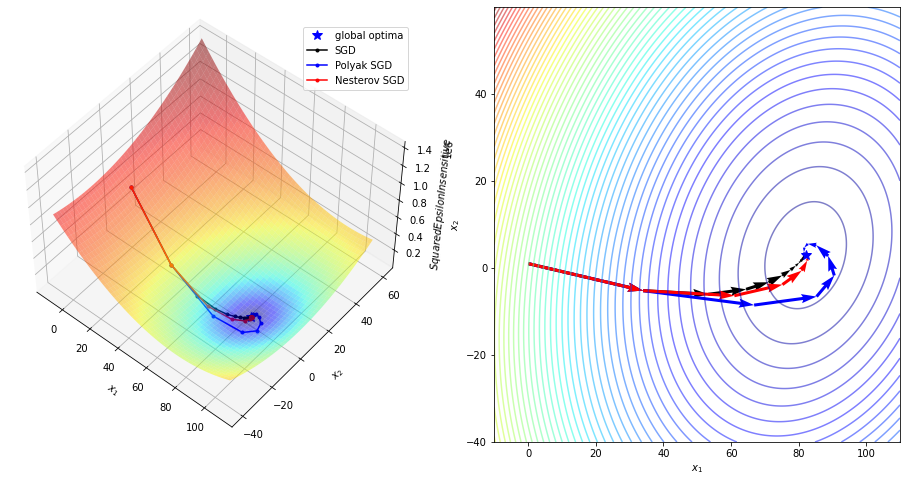

In [62]:
grid = GridSearchCV(PrimalSVR(loss=squared_epsilon_insensitive, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.002, 
                              momentum_type='nesterov', 
                              momentum=0.4, 
                              early_stopping=True, 
                              max_iter=10000, 
                              tol=1e-8, 
                              random_state=123456),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    refit='r2',  # refit the best model (wrt r2)
                    return_train_score=True,
                    verbose=2).fit(lin_X, lin_y)

squared_eps_loss_opt = plot_trajectory_optimization(squared_eps_loss_opt, grid.best_estimator_.optimizer, 
                                                    color='r', label='Nesterov SGD')
squared_eps_loss_opt.savefig('./tex/img/l2_svr_loss.png')
squared_eps_loss_opt

In [63]:
nesterov_primal_l2_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nesterov_primal_l2_svr_cv_results.insert(0, 'solver', 'sgd')
nesterov_primal_l2_svr_cv_results.insert(1, 'momentum', 'nesterov')
nesterov_primal_l2_svr_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
nesterov_primal_l2_svr_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    nesterov 1   0.1      2.522627  0.984109    2015   100
                    0.2      1.593459  0.984109    2022   100
                    0.3      1.696347  0.984109    2039    98
                10  0.1      0.224427  0.984133     247    98
                    0.2      0.231077  0.984133     248    98
                    0.3      0.251711  0.984133     248    98
                100 0.1      0.041334  0.984133      27    98
                    0.2      0.036721  0.984133      27    98
                    0.3      0.057086  0.984133      27    98

In [64]:
custom_primal_l2_svr_cv_results = none_primal_l2_svr_cv_results.append(
    polyak_primal_l2_svr_cv_results).append(
    nesterov_primal_l2_svr_cv_results)
custom_primal_l2_svr_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    none     1   0.1      2.610538  0.984109    3283   100
                    0.2      2.536275  0.984109    3294   100
                    0.3      2.622454  0.984109    3321    98
                10  0.1      0.373240  0.984133     409    98
                    0.2      0.373901  0.984133     410    98
                    0.3      0.406998  0.984133     411    98
                100 0.1      0.086858  0.984133      47    98
                    0.2      0.064771  0.984133      47    98
                    0.3      0.034043  0.984133      47    98
       polyak   1   0.1      1.642638  0.984109    2011   100
                    0.2      1.685593  0.984109    2018   100
                    0.3      1.856611  0.984109    2035    98
                10  0.1      0.233500  0.984133     241    98
                    0.2      0.233849  0.984133     242    98
                    0.3      0.260583  0.984133     243    98
                100 0.1      0.062701  0.984133      40    98
                    0.2      0.062025  0.984133      40    98
                    0.3      0.062099  0.984133      40    98
       nesterov 1   0.1      2.522627  0.984109    2015   100
                    0.2      1.593459  0.984109    2022   100
                    0.3      1.696347  0.984109    2039    98
                10  0.1      0.224427  0.984133     247    98
                    0.2      0.231077  0.984133     248    98
                    0.3      0.251711  0.984133     248    98
                100 0.1      0.041334  0.984133      27    98
                    0.2      0.036721  0.984133      27    98
                    0.3      0.057086  0.984133      27    98

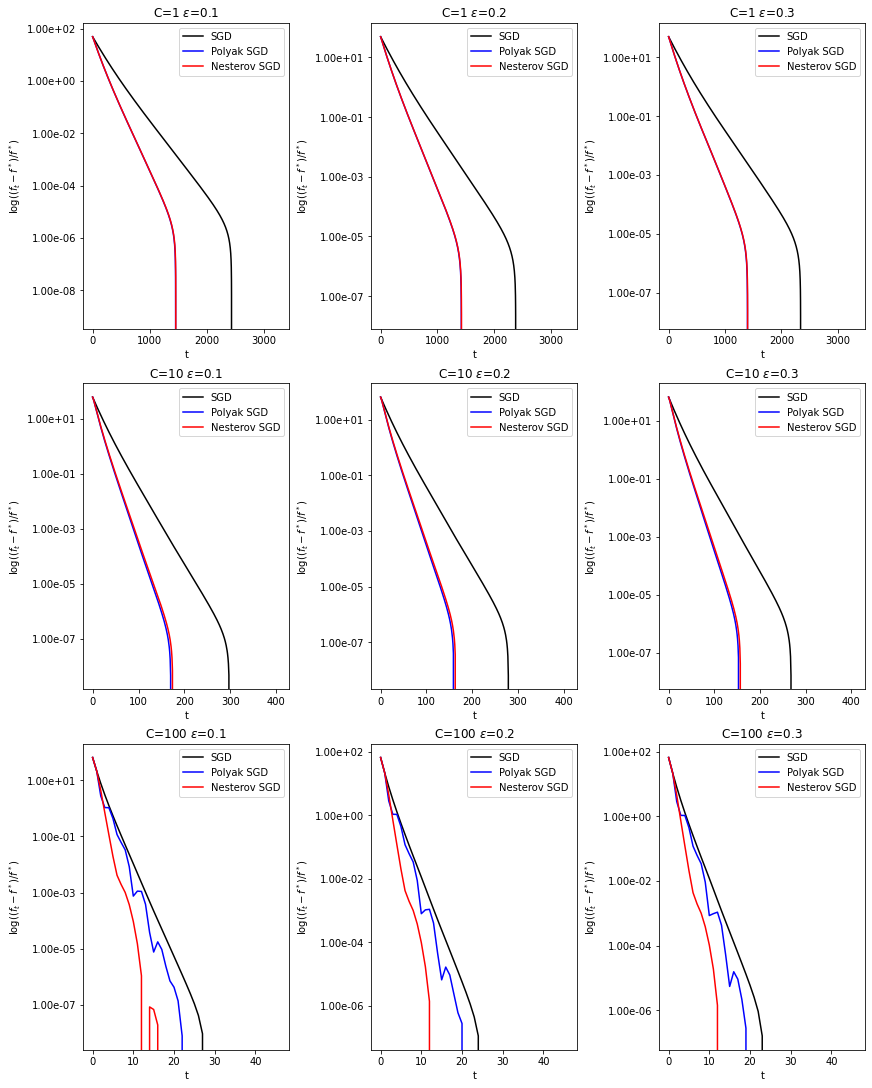

In [65]:
colors = {'none': ('k', 'SGD'),
          'polyak': ('b', 'Polyak SGD'),
          'nesterov': ('r', 'Nesterov SGD')}
axes = plt.figure(figsize=(12, 15), constrained_layout=True).subplots(3, 3)
for momentum, _dict1 in train_loss_history.items():
    for (C, _dict2), row_ax in zip(_dict1.items(), axes):
        for (eps, history), loss in zip(_dict2.items(), row_ax):
            loss.plot(history, color=colors[momentum][0], label=colors[momentum][1])
            loss.set_title('C={:d} $\epsilon$={:.1f}'.format(C, eps))
            loss.set_xlabel('t')
            loss.set_yscale('log')
            loss.set_ylabel('$\log((f_t - f^*) / f^*)$')
            loss.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
            loss.legend().get_frame().set_facecolor('white')
plt.savefig('./tex/img/l2_svr_loss_history.png')

In [66]:
grid = GridSearchCV(SkLinearSVR(loss='squared_epsilon_insensitive', 
                                max_iter=10000, 
                                random_state=123456),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2)
                    return_train_score=True,
                    verbose=2).fit(lin_X, lin_y)

Fitting 1 folds for each of 9 candidates, totalling 9 fits


In [67]:
liblinear_primal_l2_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_l2_svr_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_l2_svr_cv_results.insert(1, 'momentum', '-')
liblinear_primal_l2_svr_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
liblinear_primal_l2_svr_cv_results

fit_time        r2  n_iter  n_sv
solver    momentum C   epsilon                                  
liblinear -        1   0.1      0.002193  0.984109      84   100
                       0.2      0.003775  0.984109      84   100
                       0.3      0.006009  0.984109      84    98
                   10  0.1      0.004759  0.984133     778    98
                       0.2      0.005728  0.984133     773    98
                       0.3      0.005014  0.984133     773    98
                   100 0.1      0.055547  0.984133    7296    99
                       0.2      0.062751  0.984133    7434    98
                       0.3      0.038260  0.984133    7262    98

In [68]:
primal_l2_svr_cv_results = custom_primal_l2_svr_cv_results.append(liblinear_primal_l2_svr_cv_results)
primal_l2_svr_cv_results.to_latex('./tex/experiments/primal_l2_svr.tex', 
                                  caption='Results for the primal formulation of the $\protect \mathcal{L}_2$-SVR', 
                                  label='primal_l2_svr_cv_results', position='H')
primal_l2_svr_cv_results

fit_time        r2  n_iter  n_sv
solver    momentum C   epsilon                                  
sgd       none     1   0.1      2.610538  0.984109    3283   100
                       0.2      2.536275  0.984109    3294   100
                       0.3      2.622454  0.984109    3321    98
                   10  0.1      0.373240  0.984133     409    98
                       0.2      0.373901  0.984133     410    98
                       0.3      0.406998  0.984133     411    98
                   100 0.1      0.086858  0.984133      47    98
                       0.2      0.064771  0.984133      47    98
                       0.3      0.034043  0.984133      47    98
          polyak   1   0.1      1.642638  0.984109    2011   100
                       0.2      1.685593  0.984109    2018   100
                       0.3      1.856611  0.984109    2035    98
                   10  0.1      0.233500  0.984133     241    98
                       0.2      0.233849  0.984133     242    98
                       0.3      0.260583  0.984133     243    98
                   100 0.1      0.062701  0.984133      40    98
                       0.2      0.062025  0.984133      40    98
                       0.3      0.062099  0.984133      40    98
          nesterov 1   0.1      2.522627  0.984109    2015   100
                       0.2      1.593459  0.984109    2022   100
                       0.3      1.696347  0.984109    2039    98
                   10  0.1      0.224427  0.984133     247    98
                       0.2      0.231077  0.984133     248    98
                       0.3      0.251711  0.984133     248    98
                   100 0.1      0.041334  0.984133      27    98
                       0.2      0.036721  0.984133      27    98
                       0.3      0.057086  0.984133      27    98
liblinear -        1   0.1      0.002193  0.984109      84   100
                       0.2      0.003775  0.984109      84   100
                       0.3      0.006009  0.984109      84    98
                   10  0.1      0.004759  0.984133     778    98
                       0.2      0.005728  0.984133     773    98
                       0.3      0.005014  0.984133     773    98
                   100 0.1      0.055547  0.984133    7296    99
                       0.2      0.062751  0.984133    7434    98
                       0.3      0.038260  0.984133    7262    98

### Lagrangian Dual

In [25]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.losses import squared_epsilon_insensitive
from optiml.ml.svm.kernels import LinearKernel, LaplacianKernel, GaussianKernel
from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [26]:
train_loss_history = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

def dual_r2_scorer(svr, X, y):
    
    # (f_t - f*) / f*
    f_star = np.full_like(svr.train_loss_history, svr.obj.f_star())
    dual = 'reg_bias' if svr.reg_intercept else 'unreg_bias'
    kernel = svr.kernel.__class__.__name__
    train_loss_history[dual][kernel][svr.C][svr.epsilon] = np.divide((svr.train_loss_history - f_star), 
                                                                     np.maximum(np.abs(f_star), 1))
    
    return {'r2': svr.score(X, y), 
            'n_iter': svr.optimizer.iter + 1,  # starts from 0
            'n_sv': len(svr.support_)}

#### Linear

In [27]:
grid = GridSearchCV(DualSVR(loss=squared_epsilon_insensitive, 
                            kernel=LinearKernel(), 
                            optimizer=AdaGrad, 
                            max_iter=15000000, 
                            learning_rate=1., 
                            tol=1e-6, 
                            random_state=123456),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'reg_intercept': [True, False]},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    refit=False,
                    return_train_score=True,
                    verbose=2).fit(lin_X, lin_y)

Fitting 1 folds for each of 18 candidates, totalling 18 fits
[CV] END ...............C=1, epsilon=0.1, reg_intercept=True; total time=   6.0s
[CV] END ..............C=1, epsilon=0.1, reg_intercept=False; total time=   6.7s
[CV] END ...............C=1, epsilon=0.2, reg_intercept=True; total time=   6.4s
[CV] END ..............C=1, epsilon=0.2, reg_intercept=False; total time=   6.8s
[CV] END ...............C=1, epsilon=0.3, reg_intercept=True; total time=   6.2s
[CV] END ..............C=1, epsilon=0.3, reg_intercept=False; total time=   8.6s
[CV] END ..............C=10, epsilon=0.1, reg_intercept=True; total time= 2.1min
[CV] END .............C=10, epsilon=0.1, reg_intercept=False; total time= 2.3min
[CV] END ..............C=10, epsilon=0.2, reg_intercept=True; total time= 2.1min
[CV] END .............C=10, epsilon=0.2, reg_intercept=False; total time= 2.3min
[CV] END ..............C=10, epsilon=0.3, reg_intercept=True; total time= 2.1min
[CV] END .............C=10, epsilon=0.3, reg_int

In [28]:
linear_lagrangian_dual_l2_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
linear_lagrangian_dual_l2_svr_cv_results.sort_values(['dual', 'C'], inplace=True)
linear_lagrangian_dual_l2_svr_cv_results.set_index(['dual', 'C', 'epsilon'], inplace=True)
linear_lagrangian_dual_l2_svr_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_l2_svr.tex', 
                                                  caption='Results for the Lagrangian dual formulation of the linear $\protect \mathcal{L}_2$-SVR', 
                                                  label='linear_lagrangian_dual_l2_svr_cv_results', position='H')
linear_lagrangian_dual_l2_svr_cv_results

fit_time        r2    n_iter  n_sv
dual       C   epsilon                                        
reg_bias   1   0.1          5.964492  0.984109      8402   100
               0.2          6.434380  0.984109      8401   100
               0.3          6.194610  0.984109      8351    98
           10  0.1        127.675172  0.984133    158138    98
               0.2        123.495917  0.984133    157026    98
               0.3        123.505926  0.984133    155918    98
           100 0.1       8652.729938  0.984133  10694001    98
               0.2      10317.446609  0.984133  10606543    98
               0.3      12464.591213  0.984133  10519497    98
unreg_bias 1   0.1          6.708170  0.984109      9353   100
               0.2          6.801255  0.984109      9292   100
               0.3          8.526457  0.984109      9300    98
           10  0.1        136.818768  0.984133    172114    98
               0.2        137.433034  0.984133    170997    98
               0.3        136.082049  0.984133    169887    98
           100 0.1       8646.371154  0.984133  10814009    98
               0.2      11637.626876  0.984133  10726702    98
               0.3      14121.175771  0.984133  10639827    98

#### Nonlinear

In [29]:
grid = GridSearchCV(DualSVR(loss=squared_epsilon_insensitive, 
                            optimizer=AdaGrad, 
                            max_iter=10000000, 
                            learning_rate=1., 
                            tol=1e-6, 
                            random_state=123456),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [GaussianKernel(gamma='scale'),
                                           LaplacianKernel(gamma='scale')],
                                'reg_intercept': [True, False]},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    refit=False,
                    return_train_score=True,
                    verbose=2).fit(nonlin_X, nonlin_y)

Fitting 1 folds for each of 36 candidates, totalling 36 fits
[CV] END C=1, epsilon=0.1, kernel=GaussianKernel(), reg_intercept=True; total time=   7.2s
[CV] END C=1, epsilon=0.1, kernel=GaussianKernel(), reg_intercept=False; total time=  11.2s
[CV] END C=1, epsilon=0.1, kernel=LaplacianKernel(), reg_intercept=True; total time=   6.4s
[CV] END C=1, epsilon=0.1, kernel=LaplacianKernel(), reg_intercept=False; total time=  11.0s
[CV] END C=1, epsilon=0.2, kernel=GaussianKernel(), reg_intercept=True; total time=   7.5s
[CV] END C=1, epsilon=0.2, kernel=GaussianKernel(), reg_intercept=False; total time=  10.7s
[CV] END C=1, epsilon=0.2, kernel=LaplacianKernel(), reg_intercept=True; total time=   7.2s
[CV] END C=1, epsilon=0.2, kernel=LaplacianKernel(), reg_intercept=False; total time=  11.1s
[CV] END C=1, epsilon=0.3, kernel=GaussianKernel(), reg_intercept=True; total time=   7.6s
[CV] END C=1, epsilon=0.3, kernel=GaussianKernel(), reg_intercept=False; total time=  11.9s
[CV] END C=1, epsilo

In [30]:
nonlinear_lagrangian_dual_l2_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_lagrangian_dual_l2_svr_cv_results.sort_values(['dual', 'kernel'], inplace=True)
nonlinear_lagrangian_dual_l2_svr_cv_results.set_index(['dual', 'kernel', 'C', 'epsilon'], inplace=True)
nonlinear_lagrangian_dual_l2_svr_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_l2_svr.tex', 
                                                     caption='Results for the Lagrangian dual formulation of the nonlinear $\protect \mathcal{L}_2$-SVR', 
                                                     label='nonlinear_lagrangian_dual_l2_svr_cv_results', position='H')
nonlinear_lagrangian_dual_l2_svr_cv_results

fit_time        r2  n_iter  n_sv
dual       kernel    C   epsilon                                    
reg_bias   gaussian  1   0.1        7.135524  0.971405    7093    35
                         0.2        7.499573  0.932771    7186    28
                         0.3        7.569210  0.897683    7323    16
                     10  0.1       29.186773  0.980109   32732    18
                         0.2       22.800884  0.915558   26067     9
                         0.3       22.554511  0.896923   25622     8
                     100 0.1      239.380059  0.985273  274625    20
                         0.2       86.957817  0.924205   24585     6
                         0.3       20.934352  0.881670   16620     5
           laplacian 1   0.1        6.362951  0.968637    7538    51
                         0.2        7.175239  0.934767    7731    41
                         0.3        6.415031  0.888289    7826    33
                     10  0.1       27.583155  0.983604   31614    24
                         0.2       21.833504  0.934553   24740    18
                         0.3       20.415103  0.910527   21944    13
                     100 0.1      206.555819  0.980213   89197    23
                         0.2       99.340264  0.941097   38347    13
                         0.3      123.114494  0.865075   34054     9
unreg_bias gaussian  1   0.1       11.183639  0.971405   12843    35
                         0.2       10.648331  0.932774   13050    28
                         0.3       11.861509  0.897714   13208    16
                     10  0.1       48.657613  0.980097   56316    18
                         0.2       40.043627  0.915598   44173     9
                         0.3       37.530801  0.897112   41754     8
                     100 0.1      571.308234  0.985307  452624    20
                         0.2      124.033677  0.924509   37779     6
                         0.3       56.249841  0.881853   32359     5
           laplacian 1   0.1       10.942949  0.968636   13141    51
                         0.2       11.056578  0.934768   13377    41
                         0.3       11.796027  0.888284   13578    33
                     10  0.1       43.131174  0.983603   50171    24
                         0.2       35.701638  0.934550   40089    18
                         0.3       31.360451  0.910527   34849    13
                     100 0.1      308.013989  0.980228  124931    23
                         0.2       84.984370  0.941102   60828    13
                         0.3      165.707298  0.865108   53817     9

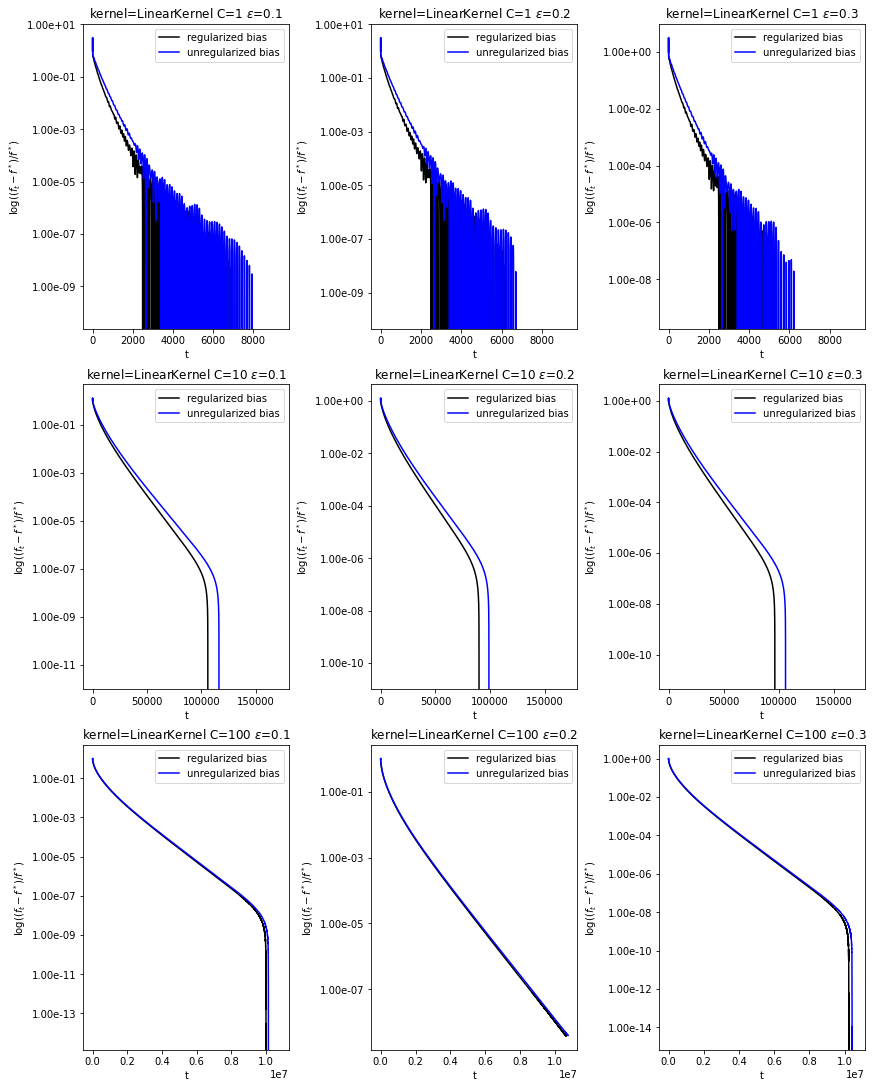

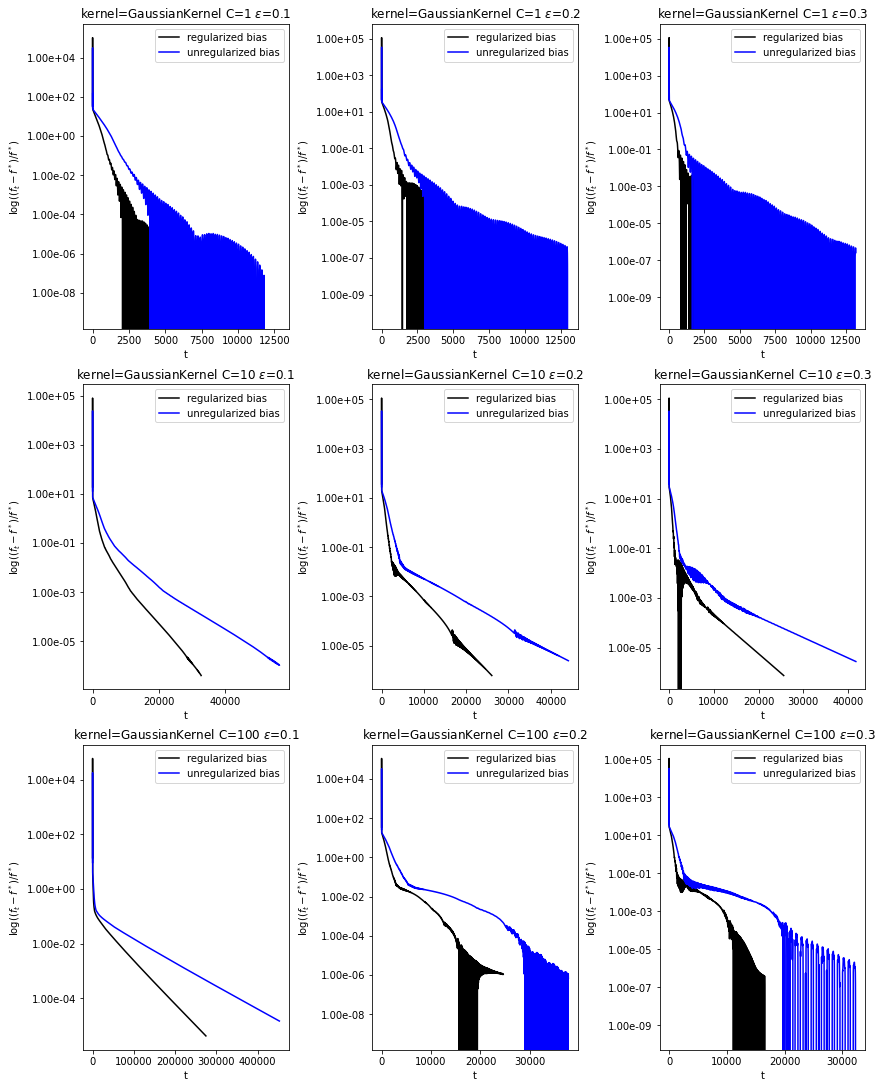

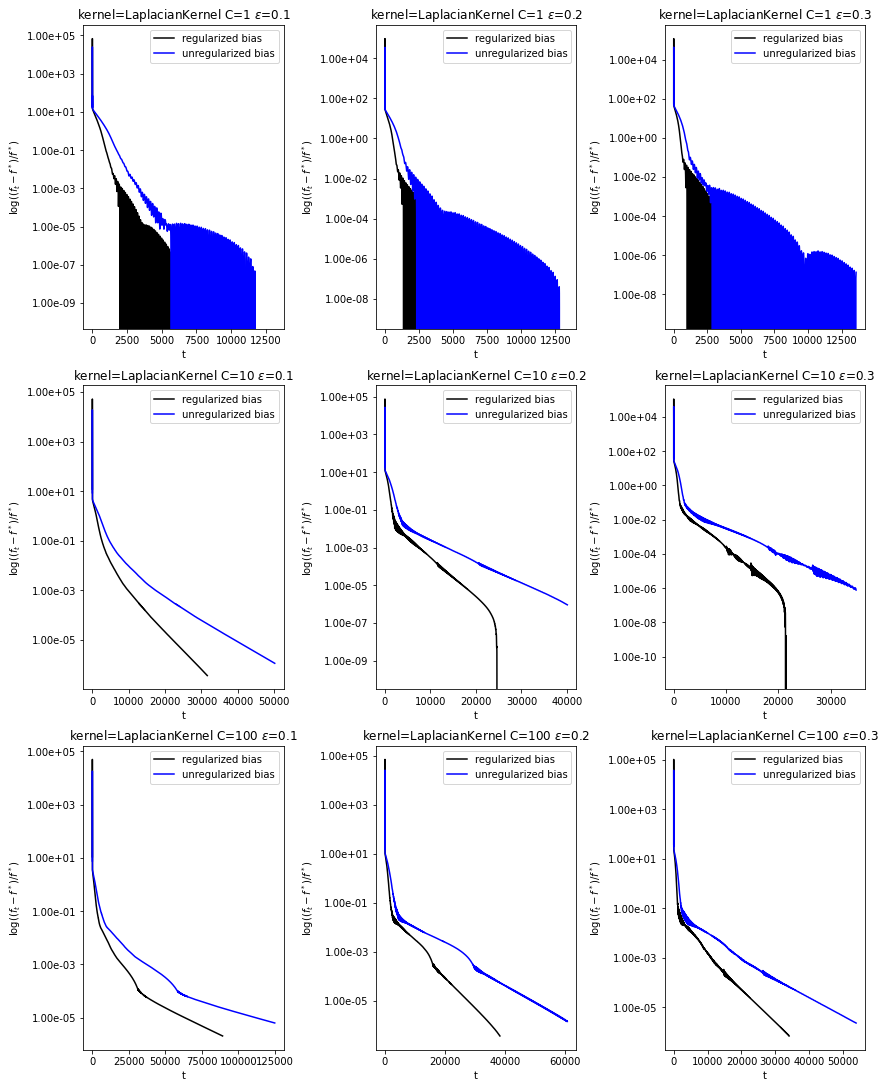

In [34]:
colors = {'reg_bias': ('k', 'regularized bias'),
          'unreg_bias': ('b', 'unregularized bias')}
linear_fig = plt.figure(figsize=(12, 15), constrained_layout=True)
linear_ax = linear_fig.subplots(3, 3)
gaussian_fig = plt.figure(figsize=(12, 15), constrained_layout=True)
gaussian_ax = gaussian_fig.subplots(3, 3)
laplacian_fig = plt.figure(figsize=(12, 15), constrained_layout=True)
laplacian_ax = laplacian_fig.subplots(3, 3)
axes = {'LinearKernel': linear_ax,
        'LaplacianKernel': laplacian_ax,
        'GaussianKernel': gaussian_ax}
for dual, _dict1 in train_loss_history.items():
    for kernel, _dict2 in _dict1.items():
        for (C, _dict3), row_ax in zip(_dict2.items(), axes[kernel]):
            for (eps, history), loss in zip(_dict3.items(), row_ax):
                loss.plot(history, color=colors[dual][0], label=colors[dual][1])
                loss.set_title('kernel={} C={:d} $\epsilon$={:.1f}'.format(kernel, C, eps))
                loss.set_xlabel('t')
                loss.set_yscale('log')
                loss.set_ylabel('$\log((f_t - f^*) / f^*)$')
                loss.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
                loss.legend().get_frame().set_facecolor('white')
linear_fig.savefig('./tex/img/linear_lagrangian_dual_l2_svr_loss_history.png')
gaussian_fig.savefig('./tex/img/gaussian_lagrangian_dual_l2_svr_loss_history.png')
laplacian_fig.savefig('./tex/img/laplacian_lagrangian_dual_l2_svr_loss_history.png')